# **Muhammad Deedahwar Mazhar Qureshi**

# **CMS: 243516**

# **BESE-9A**

# **Machine Learning Lab 05**

## Deep Neural Network and Regularization

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

In [33]:
# import packages to use
import numpy as np
from collections import OrderedDict
import scipy
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as f

# for reproduciblity
torch.manual_seed(0)
np.random.seed(0)
import random
random.seed(0)

In [34]:
# Some helper functions
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    d = np.c_[xx.ravel(), yy.ravel()]
    # Predict the function value for the whole grid
    Z = model.predict(torch.from_numpy(d.astype('float32')))
    Z = torch.argmax(Z, dim=1)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z.detach().numpy(), cmap=plt.cm.Spectral, alpha=.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.title('Decision Boundary')
    plt.show()

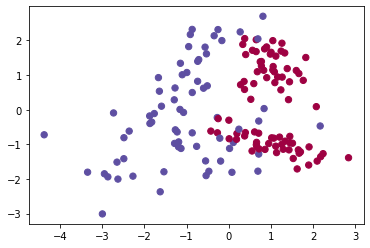

In [35]:
# Loading the training datd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import model_selection

X, Y = make_classification(n_samples = 300, n_features=2, 
                           n_redundant=0, n_informative=2,
                           random_state = np.random.seed(8),
                           flip_y = .001)
Y = 1-Y
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.50, random_state=2)

model_selection.train_test_split(X)

train_X =  torch.from_numpy(train_X.astype('float32'))
train_Y =  torch.from_numpy(train_Y.astype('int64'))
test_X =  torch.from_numpy(test_X.astype('float32'))
test_Y =  torch.from_numpy(test_Y.astype('int64'))


plt.scatter(train_X[:,0], train_X[:,1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()


Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a classification algorithm to find the positions on the field where the goalkeeper should kick the ball.

## Logistic Regression Model
You will first try a logistic regression model, which has been implemented below. Go through the model, which is similar to the last lab logistic regression model. However, here Object oriented programming (using classes) principles have been used. From now onwards this is how you will implement a model/hypothesis. Secondly, we have used nn.CrossEntropyLoss(). This criterion combines LogSoftmax and NLLLoss in one single class. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [36]:
# simple logistic regression model
class model01(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.linear = nn.Linear(in_dim, out_dim)
        
    def predict(self, x):
        return f.softmax(self.linear(x), dim=1)
        
    def forward(self, x):
        return self.linear(x)

In [37]:
# Training the model
model = model01(2,2)
cost = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = .1, weight_decay=0)

J_history = []
for iterations in range(10000):
    optimizer.zero_grad()
    # forward pass
    out = model(train_X)
    
    loss = cost(out, train_Y)
    
    # backward pass
    loss.backward()
    
    # update paramters
    optimizer.step()
    
    J_history += [loss.item()]


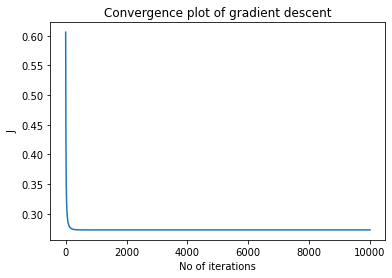

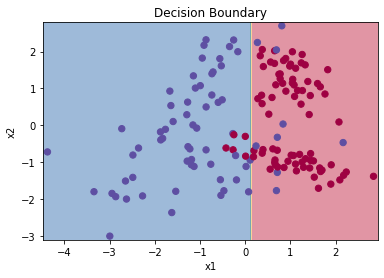

Train Error: 0.27305272221565247, Test Error: 0.3072413504123688
Train Accuracy: 90.66666412353516, Test Accuracy: 88.0


In [38]:
# plot the results
from matplotlib import pyplot as plt
plt.plot(J_history)
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of iterations')
plt.ylabel('J')
plt.show()

plot_decision_boundary(model, train_X, train_Y)

# Print train and test error and accuracy
out = model(train_X)
loss_train = cost(out, train_Y)
out = model(test_X)
loss_test = cost(out, test_Y)
print(f'Train Error: {loss_train.item()}, Test Error: {loss_test.item()}')

out = torch.argmax(model.predict(train_X), dim=1)
loss_train = 100.*torch.sum(out == train_Y)/out.shape[0]
out = torch.argmax(model.predict(test_X), dim=1)
loss_test = 100.*torch.sum(out == test_Y)/out.shape[0]
print(f'Train Accuracy: {loss_train}, Test Accuracy: {loss_test}')

The model you implement above (also called Perceptron) can be represented pictorially as:

<img src="images/perceptron.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 2** </u>: **Perceptron**<br> </center></caption>

This is a linear model and therefore it has a linear decision boundary. This is the best you can get from a linear decision boundary. In order to have a non-linear decision boundary, we need to have Deep Learning model. 

Deep learning models have so much flexibility and capacity that overfitting can be a serious problem, if the training dataset is not big enough. Sure it does well on the training set, but the learned network doesn't generalize to new examples that it has never seen!

<img src="images/dl.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 3** </u>: **Deep Neural Network**<br> </center></caption>


## Lab Task 1 - Implement Deep Learning Model
Implement a neural network with two hidden layers. In the first hidden layer, you will have 20 neuron and in the second 3 neurons. Use ReLU activation unit.

Use following to implement the deep network
 - nn.Sequential
 - nn.Linear
 - nn.ReLU

In [39]:
class model02(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        hidden=[20,3]
        
        # todo. Chamnge the model to include more layers
        self.feat=nn.Sequential(OrderedDict([
            ('layer1',nn.Linear(in_dim, hidden[0])),
            ('relu1',nn.ReLU()),
            ('layer2',nn.Linear(hidden[0], hidden[1])),
            ('relu2',nn.ReLU()),
            ('layer3',nn.Linear(hidden[1], out_dim))
            
            
        ])) 
       
        
    def predict(self, x):
        return f.softmax(self.feat(x), dim=1)
        
    def forward(self, x):
        return self.feat(x)

In [43]:
model = model02(2,2)
cost = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = .1, weight_decay=0)

J_history = []
for iterations in range(10000):
    optimizer.zero_grad()
    # forward pass
    out = model(train_X)
    
    loss = cost(out, train_Y)
    
    # backward pass
    loss.backward()
    
    # update paramters
    optimizer.step()
    
    J_history += [loss.item()]

model


model02(
  (feat): Sequential(
    (layer1): Linear(in_features=2, out_features=20, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=20, out_features=3, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=3, out_features=2, bias=True)
  )
)

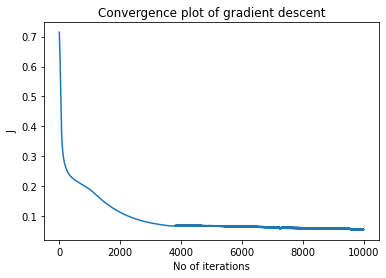

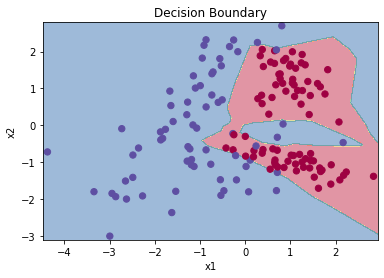

Train Accuracy: 96.66666412353516, Test Accuracy: 92.66666412353516


In [44]:
# plot the results
from matplotlib import pyplot as plt
plt.plot(J_history)
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of iterations')
plt.ylabel('J')
plt.show()

plot_decision_boundary(model, train_X, train_Y)

#print accuracy
out = torch.argmax(model.predict(train_X), dim=1)
loss_train = 100*torch.sum(out == train_Y)/out.shape[0]
out = torch.argmax(model.predict(test_X), dim=1)
loss_test = 100*torch.sum(out == test_Y)/out.shape[0]
print(f'Train Accuracy: {loss_train}, Test Accuracy: {loss_test}')

The model training accuracy has improved, however the test accuracy has not improved relatively. This is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting. 

## Lab Task 2 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. L2 regularization makes your decision boundary smoother. To use L2 Regularization, use **weight_decay** parameter of the optimizer above (optimizer = optim.SGD(model.parameters(), lr = .1, weight_decay=0)). <p style="color:red;">Report train and test accuracy by using different values of weight_decay and find the optimal value.</p> If weight_decay is too large, it is also possible to "oversmooth", resulting in a model with high bias.

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. [Please revisit the lab after we have covered Regularization in the class]


In [45]:
weight_decay_list=[0, 0.1, 0.01, 0.001, 0.0001, 1, 10]
for x in weight_decay_list:
  model = model02(2,2)
  cost = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = .1, weight_decay=x)

  J_history = []
  for iterations in range(10000):
      optimizer.zero_grad()
    # forward pass
      out = model(train_X)
    
      loss = cost(out, train_Y)
    
    # backward pass
      loss.backward()
    
    # update paramters
      optimizer.step()
    
      J_history += [loss.item()]

# plot the results

  #plt.plot(J_history)
  #plt.title('Convergence plot of gradient descent')
  #plt.xlabel('No of iterations')
  #plt.ylabel('J')
  #plt.show()

  #plot_decision_boundary(model, train_X, train_Y)

#print accuracy
  out = torch.argmax(model.predict(train_X), dim=1)
  loss_train = 100*torch.sum(out == train_Y)/out.shape[0]
  out = torch.argmax(model.predict(test_X), dim=1)
  loss_test = 100*torch.sum(out == test_Y)/out.shape[0]
  print(f'Train Accuracy: {loss_train}, Test Accuracy: {loss_test}, Weight Decay:{x}')


Train Accuracy: 97.33333587646484, Test Accuracy: 92.66666412353516, Weight Decay:0
Train Accuracy: 90.0, Test Accuracy: 88.0, Weight Decay:0.1
Train Accuracy: 92.66666412353516, Test Accuracy: 94.66666412353516, Weight Decay:0.01
Train Accuracy: 94.66666412353516, Test Accuracy: 93.33333587646484, Weight Decay:0.001
Train Accuracy: 95.33333587646484, Test Accuracy: 93.33333587646484, Weight Decay:0.0001
Train Accuracy: 54.66666793823242, Test Accuracy: 45.33333206176758, Weight Decay:1
Train Accuracy: 54.66666793823242, Test Accuracy: 45.33333206176758, Weight Decay:10


A Weight Decay of 0.0001 gives 93.33 Test Accuracy and a 95.33 Train Accuracy score which suggests that there was an even increase in both test and train accuracies and the data did not get overfitted. 
Therefore, 
Optimal_Weight_Decay = 0.001

We can see data get oversmoothed at weight decays of 1 and 10. 

We can see overfitting of data at 0 and 0.1

## Lab Task 3 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** Watch these two videos to see what this means!

<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figure 4 </u>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

<p style="color:red;"> Use nn.DropOut in your model to use the dropout regularization and report train and test errors. What is the best Dropout rate for the problem above? <p>

In [46]:
class model03(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate):
        super().__init__()
        hidden=[20,3]
        
        # todo. Chamnge the model to include more layers
        self.feat=nn.Sequential(OrderedDict([
            ('layer1',nn.Linear(in_dim, hidden[0])),
            ('relu1',nn.ReLU()),
            ('dropout1', nn.Dropout(dropout_rate)),
            ('layer2',nn.Linear(hidden[0], hidden[1])),
            ('relu2',nn.ReLU()),
            ('dropout2', nn.Dropout(dropout_rate)),
            ('layer3',nn.Linear(hidden[1], out_dim))
            
            
        ])) 
       
        
    def predict(self, x):
        return f.softmax(self.feat(x), dim=1)
        
    def forward(self, x):
        return self.feat(x)

In [47]:
dropout_rate_list = np.linspace(0,1,11)
for d in dropout_rate_list:
  current_model = model03(2,2,d)
  cost_current = nn.CrossEntropyLoss()
  optimizer= optim.SGD(current_model.parameters(), lr = .1, weight_decay = 0)

  for iterations in range(10000):
      optimizer.zero_grad()
    # forward pass
      out = current_model(train_X)
    
      loss = cost_current(out, train_Y)
    
    # backward pass
      loss.backward()
    
    # update paramters
      optimizer.step()
    

  out = torch.argmax(current_model.predict(train_X), dim=1)
  loss_train = 100*torch.sum(out == train_Y)/out.shape[0]
  out = torch.argmax(current_model.predict(test_X), dim=1)
  loss_test = 100*torch.sum(out == test_Y)/out.shape[0]
  print(f'Train Accuracy: {loss_train}, Test Accuracy: {loss_test}, Dropout Rate:{d}')

Train Accuracy: 98.0, Test Accuracy: 92.0, Dropout Rate:0.0
Train Accuracy: 96.66666412353516, Test Accuracy: 90.66666412353516, Dropout Rate:0.1
Train Accuracy: 92.66666412353516, Test Accuracy: 94.0, Dropout Rate:0.2
Train Accuracy: 92.0, Test Accuracy: 86.66666412353516, Dropout Rate:0.30000000000000004
Train Accuracy: 88.0, Test Accuracy: 83.33333587646484, Dropout Rate:0.4
Train Accuracy: 82.66666412353516, Test Accuracy: 80.66666412353516, Dropout Rate:0.5
Train Accuracy: 77.33333587646484, Test Accuracy: 90.0, Dropout Rate:0.6000000000000001
Train Accuracy: 74.0, Test Accuracy: 66.0, Dropout Rate:0.7000000000000001
Train Accuracy: 65.33333587646484, Test Accuracy: 61.33333206176758, Dropout Rate:0.8
Train Accuracy: 60.66666793823242, Test Accuracy: 48.0, Dropout Rate:0.9
Train Accuracy: 54.66666793823242, Test Accuracy: 45.33333206176758, Dropout Rate:1.0


According to the results above, the optimal dropout rate would be 0.2 as the data seems to be regularized the best and there is an even increase increase in accuracies for test and train.